In [1]:
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
def convert_time(arrival_time_str, format='%H:%M:%S'):
    arrival_time_str_split = arrival_time_str.split(":")
    isArrNextDay = int(arrival_time_str_split[0]) >= 24
    if isArrNextDay:
        arrival_time_str = str(int(arrival_time_str_split[0]) % 24)
        for s in [":" + a for  a in arrival_time_str_split[1:]]:
            arrival_time_str += s

    arrival_time = datetime.datetime.strptime(arrival_time_str, format)

    if isArrNextDay:
        arrival_time = datetime.datetime(year=1900, month=1, day=arrival_time.day + 1, hour=arrival_time.hour, minute=arrival_time.minute, second=arrival_time.second)

    return arrival_time

In [3]:
RAWDATAPATH = r"C:\Users\Martin Tosstorff\Downloads\google_transit(1)"
UBAHNROUTEID = 402

In [4]:
routes_df = pd.read_csv(os.path.join(RAWDATAPATH, 'routes.txt'))
trips_df = pd.read_csv(os.path.join(RAWDATAPATH, 'trips.txt'))
stops_df = pd.read_csv(os.path.join(RAWDATAPATH, 'stops.txt'))
stop_times_df = pd.read_csv(os.path.join(RAWDATAPATH, 'stop_times.txt'))
calendar_df = pd.read_csv(os.path.join(RAWDATAPATH, 'calendar.txt'))

service = calendar_df[calendar_df['monday'] == 1]["service_id"].unique()
trips_df = trips_df[trips_df["service_id"].isin(service)]

In [5]:
mask = routes_df.route_type == UBAHNROUTEID
route_ids = routes_df[mask].route_id

In [6]:
trips_df = trips_df[trips_df.route_id.isin(route_ids)]
trip_ids = trips_df.trip_id

In [7]:
stop_times_df = stop_times_df[stop_times_df.trip_id.isin(trip_ids)]
stop_ids = stop_times_df.stop_id

In [8]:
stops_df = stops_df[stops_df.stop_id.isin(stop_ids)]

In [9]:
merged_data = pd.merge(stop_times_df, stops_df, left_on="stop_id", right_on="stop_id")
merged_data = pd.merge(merged_data, trips_df, left_on="trip_id", right_on="trip_id")
merged_data = pd.merge(merged_data, routes_df, left_on="route_id", right_on="route_id")
merged_data.arrival_time = merged_data.arrival_time.transform(convert_time)
merged_data.departure_time = merged_data.departure_time.transform(convert_time)

In [10]:
start = datetime.datetime(year=1900, month=1, day=1, hour=13, minute=0, second=0)
end = datetime.datetime(year=1900, month=1, day=1, hour=14, minute=30, second=0)

In [11]:
merged_data.route_color = merged_data.route_color.transform(lambda c : '#' + c)

In [12]:
merged_data = merged_data[(merged_data.departure_time > start) & (merged_data.arrival_time < end)] 

# Exercise 2:

In [13]:
def draw_locations(names, lons, lats, colors, graph=None):
    if type(names) == pd.core.series.Series:
        names = names.tolist()
    if type(lons) == pd.core.series.Series:
        lons = lons.tolist()
    if type(lats) == pd.core.series.Series:
        lats = lats.tolist()
    if type(colors) == pd.core.series.Series:
        colors = colors.tolist()
        
    if graph is None:
        graph = nx.Graph()
        for n in names:
            graph.add_node(n)
        
    pos = {}
    label_pos={}
    color_dic = {}
    fig, ax = plt.subplots(figsize=(12,12))
    
    for n in graph.nodes:
        pos[n] = (lons[names.index(n)], lats[names.index(n)])
        label_pos[n] = (lons[names.index(n)], lats[names.index(n)] + 0.002)
        color_dic[n] = colors[names.index(n)]
        
    
    #nx.draw(graph, pos, color=color_dic)
    nx.draw_networkx_nodes(graph, pos, node_color=list(color_dic.values()), node_size=50)
    nx.draw_networkx_labels(graph, label_pos, font_size=10)
    nx.draw_networkx_edges(graph, pos)
    

### Example for drawing loacations:

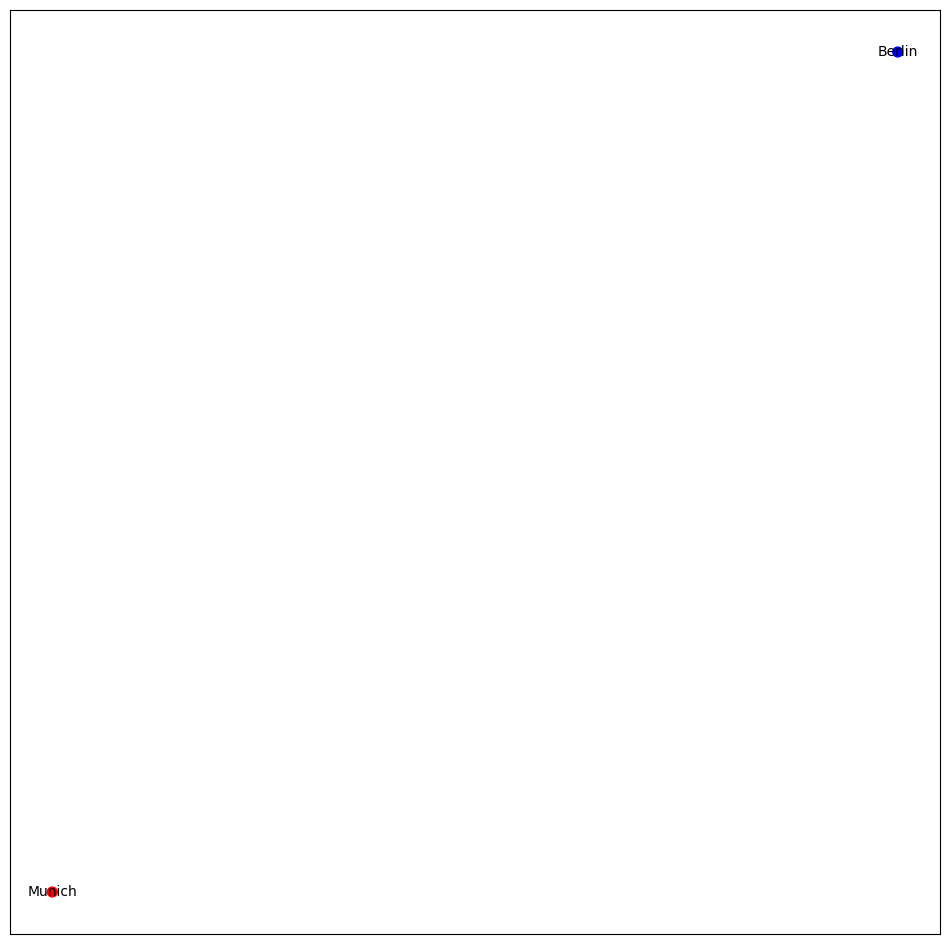

In [14]:
#example how to draw locations
draw_locations(['Munich', 'Berlin'], [11.576124, 13.404954], [48.137154, 52.520008], ['red', 'blue'])

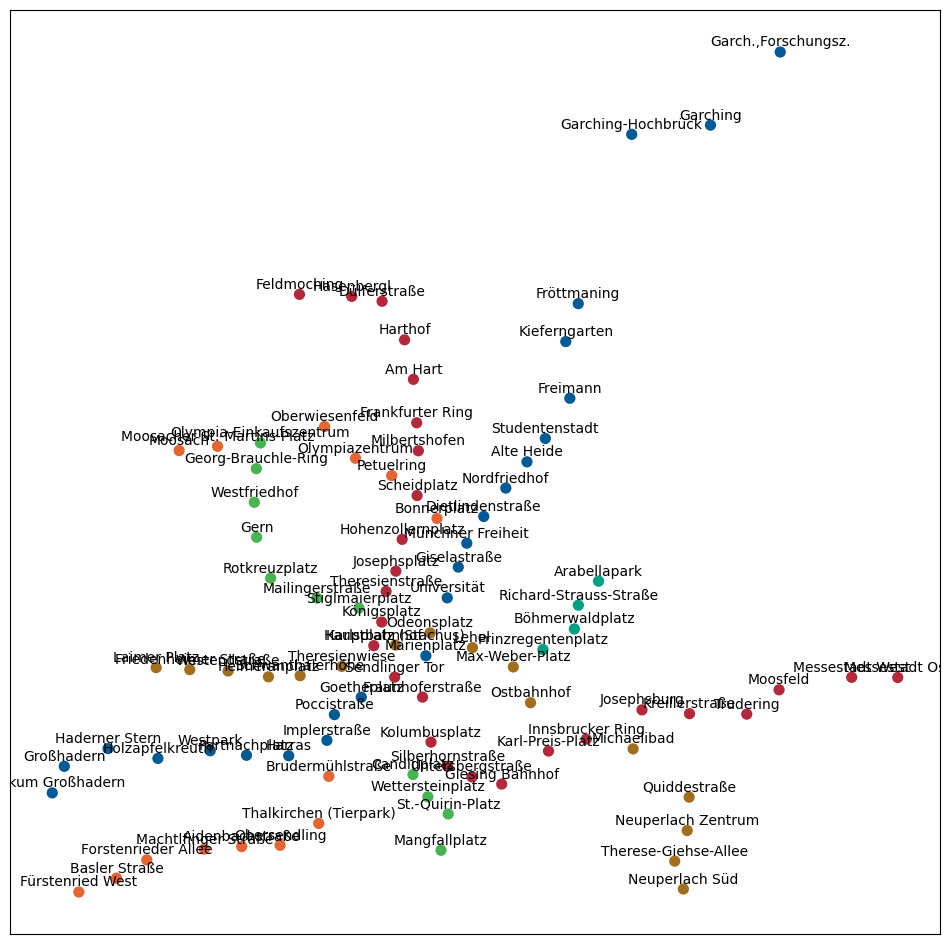

In [15]:
draw_locations(merged_data.stop_name, merged_data.stop_lon, merged_data.stop_lat, merged_data.route_color);

# Exercise 2:

### Example how to create a graph

In [16]:
hochbruck = 'Garching-Hochbrück'
garching = 'Garching'
#Create graph
graph = nx.Graph()
#Add node for station 'Garching-Hochbrück'
graph.add_node(hochbruck)
#Add edge between stations 'Garching' and 'Garching-Hochbrück'
graph.add_edge(garching, hochbruck)

In [17]:
graph = nx.Graph()
for k,g in merged_data.groupby('trip_id'):
    stop_location_sequence = g.sort_values('arrival_time')
    for si in range(len(stop_location_sequence) - 1):
        graph.add_edge(stop_location_sequence.iloc[si]['stop_name'], stop_location_sequence.iloc[si+1]['stop_name'])   


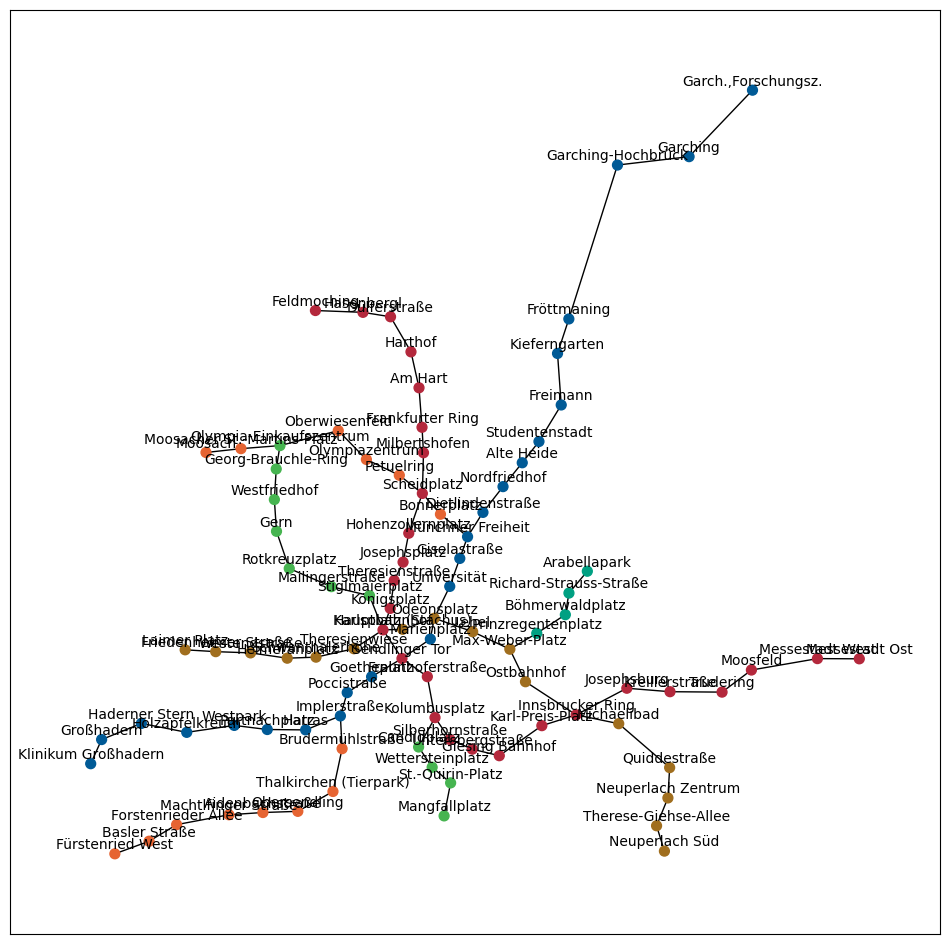

In [18]:
draw_locations(merged_data.stop_name, merged_data.stop_lon, merged_data.stop_lat, merged_data.route_color, graph)    

# Exercise 4:

In [19]:
U6_route_id = '1-U6-G-014-1'
u6_df = merged_data[merged_data.route_id == U6_route_id]

In [20]:
line_graph = nx.Graph()
for ki, (k, g) in enumerate(u6_df.groupby(['trip_id'])):    
    row_iter = g.sort_values(by='arrival_time').iterrows()
    last_stop=None
    for ri, row in row_iter:
        if last_stop:
            line_graph.add_edge((row.trip_id, last_stop, 'd'), (row.trip_id, row.stop_name, 'a'))
        line_graph.add_edge((row.trip_id, row.stop_name, 'a'), (row.trip_id, row.stop_name, 'd'))
        last_stop = row.stop_name                

In [21]:
def draw_line_graph(line_graph, merge_data, route_id):
    line_df = merged_data[merged_data.route_id == route_id]
    trip_groups = list(line_df.groupby(['trip_id']))
    representative_trip_id, representative_rows  = sorted(trip_groups, key = lambda kg : len(kg[1]))[-1]
    stop_name_sequence = representative_rows.sort_values('arrival_time')['stop_name'].tolist()
    pos = {}
    for n in line_graph.nodes:
        row = line_df[(line_df.trip_id == n[0]) & (line_df.stop_name == n[1])].iloc[0]
        pos[n] = (stop_name_sequence.index(n[1]), (row['arrival_time'] - start).seconds if n[2] == 'a' else (row['departure_time'] - start).seconds)

    fig, ax = plt.subplots()
    nx.draw(line_graph, pos, node_size=1)
    ax = plt.gca()  # Get current axis
    ax.set_axis_on()  # Turn the axis back on
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks are displayed
    ax.set_ylabel('Time [s]')
    plt.xticks(list(range(len(stop_name_sequence))), stop_name_sequence, rotation=90)
    plt.show()
        

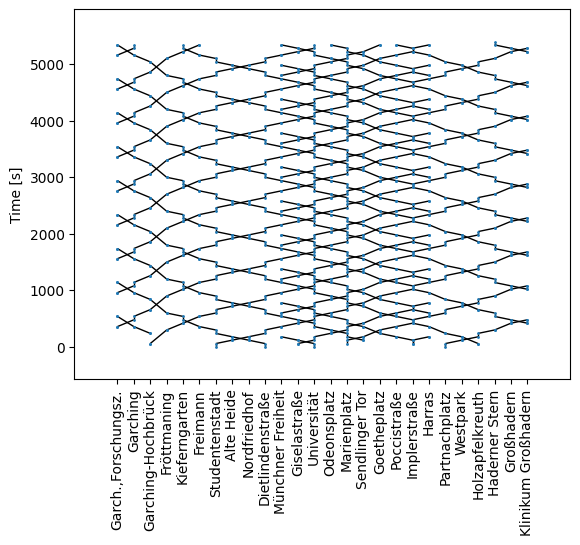

In [22]:
draw_line_graph(line_graph, merged_data, U6_route_id)